# The Reuters Corpus

## Question

Can we predict whether an article is positive or negative based on how many times the article uses each of the 100 most common tokens across all articles

In [1]:
# importing necessary packages
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
from collections import Counter
import numpy as np
import pandas as pd

nltk.download('punkt') # for tokenizing


# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("../downloads/STA380-master/STA380-master/data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("../downloads/STA380-master/STA380-master/data/ReutersC50/C50test")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ianwm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Approach

We first create a train and test set. Each of the sets will have information on 2500 articles, 50 for each of the 50 authors. For each article, we will have a column for each of the 100 most common tokens that shows how many times each token was used in the article. We will then, train and fit a Gradient Boosting Decision Tree model on the training set, then test the model on the test set.

In [2]:
# import Sentiment Analyzer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', download_dir='C:\\Users\\ianwm\\STA380')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ianwm\STA380...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# get polarity scores for train set
train_polarity_scores = []
for text in train_texts:
    if (sia.polarity_scores(text)['compound']) > 0:
        train_polarity_scores.append(True)
    else:
        train_polarity_scores.append(False)
#train_polarity_scores

In [4]:
# get polarity scores for test set
test_polarity_scores = []
for text in test_texts:
    if (sia.polarity_scores(text)['compound']) > 0:
        test_polarity_scores.append(True)
    else:
        test_polarity_scores.append(False)
#test_polarity_scores

In [5]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ianwm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# preprocess all texts
texts = [(preprocess_text(text)) for text in (train_texts + test_texts)]

In [7]:
# get 100 most common tokens
all_tokens = [token for text in (train_texts + test_texts) for token in preprocess_text(text)]
common_tokens = Counter(all_tokens).most_common(100)

In [8]:
# find how many times each of most common tokens is in each article for train set
texts = [(preprocess_text(text)) for text in (train_texts)]
labels = np.zeros((len(common_tokens), len(train_labels)))
for i, token in enumerate(common_tokens):
    for j, text in enumerate(texts):
        words = texts[j]
        for word in words:
            if word in token[0]:
                #print(i,j)
                labels[i, j] += 1

In [9]:
# create training data frame with number of times each of most common tokens is in each article, as well as whether the article is positive or negative
labelsDF = pd.DataFrame({})
for i in range(len(labels)):
    labelsDF[common_tokens[i][0]] = labels[i]
labelsDF
happy = pd.DataFrame({'happy': (train_polarity_scores)})
traindf = happy.merge(labelsDF, left_index = True, right_index = True)
traindf

,happy,said,'s,'',``,year,compani,percent,would,million,...,secur,sinc,call,foreign,continu,still,develop,comput,around,gener
0,False,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,False,8.0,2.0,5.0,5.0,0.0,0.0,0.0,1.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0
2,True,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,7.0,2.0,6.0,7.0,1.0,2.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
4,True,3.0,2.0,5.0,6.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,False,9.0,4.0,7.0,7.0,4.0,3.0,9.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2496,True,6.0,10.0,8.0,8.0,6.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2497,False,5.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,False,8.0,4.0,6.0,6.0,10.0,3.0,6.0,5.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


In [10]:
# find how many times each of most common tokens is in each article for test set
texts = [(preprocess_text(text)) for text in (test_texts)]
labels = np.zeros((len(common_tokens), len(test_labels)))
for i, token in enumerate(common_tokens):
    for j, text in enumerate(texts):
        words = texts[j]
        for word in words:
            if word in token[0]:
                #print(i,j)
                labels[i, j] += 1

In [11]:
# create test data frame with number of times each of most common tokens is in each article, as well as whether the article is positive or negative
labelsDF = pd.DataFrame({})
for i in range(len(labels)):
    labelsDF[common_tokens[i][0]] = labels[i]
labelsDF
happy = pd.DataFrame({'happy': (test_polarity_scores)})
testdf = happy.merge(labelsDF, left_index = True, right_index = True)
testdf

,happy,said,'s,'',``,year,compani,percent,would,million,...,secur,sinc,call,foreign,continu,still,develop,comput,around,gener
0,False,12.0,3.0,11.0,11.0,0.0,6.0,0.0,4.0,1.0,...,9.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,False,3.0,3.0,7.0,7.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,True,9.0,8.0,11.0,11.0,1.0,2.0,3.0,0.0,1.0,...,0.0,2.0,6.0,1.0,1.0,1.0,2.0,7.0,5.0,0.0
3,True,6.0,0.0,3.0,3.0,0.0,5.0,0.0,2.0,0.0,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0
4,True,5.0,4.0,10.0,10.0,1.0,0.0,1.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,True,8.0,1.0,6.0,6.0,7.0,1.0,11.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2496,True,8.0,1.0,6.0,6.0,7.0,1.0,11.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2497,True,6.0,2.0,3.0,3.0,1.0,11.0,0.0,1.0,1.0,...,2.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,0.0,0.0
2498,False,11.0,5.0,9.0,9.0,8.0,0.0,4.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
# create X_train, y_train, X_test, y_test
X_train = traindf.drop(['happy'], axis = 1)
y_train = traindf['happy']
X_test =  testdf.drop(['happy'], axis = 1)
y_test = testdf['happy']

In [13]:
# create model
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=200,
                               max_depth=4,
                               random_state=1)

In [14]:
# fit model
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=200, random_state=1)

In [15]:
# test model
from sklearn import metrics
prediction_test = model.predict(X_test)
accuracy_test = metrics.accuracy_score(y_test, prediction_test)
accuracy_test

0.7588

## Results

Our initial model is able to predict whether the article is positive or negative with an accuracy of 75.88%. 

<Axes: xlabel='Number of trees in ensemble', ylabel='Test accuracy'>

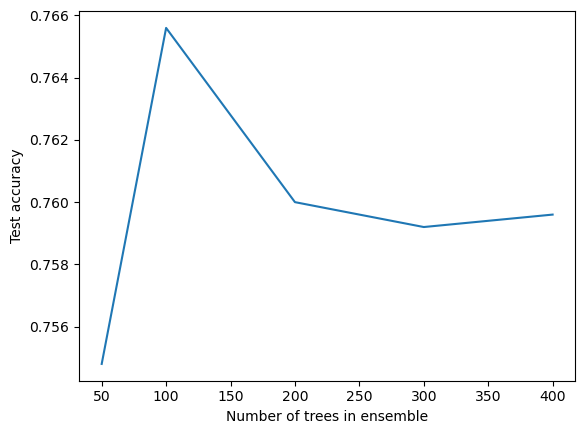

In [16]:
# testing different values for number of trees to see which value should produce the highest accuracy
from pandas import Series, DataFrame
scores = {}
for num_trees in [50, 100, 200, 300, 400]:
    model = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=2,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot(xlabel = 'Number of trees in ensemble', ylabel = 'Test accuracy')

<Axes: xlabel='Depth of trees in ensemble', ylabel='Test accuracy'>

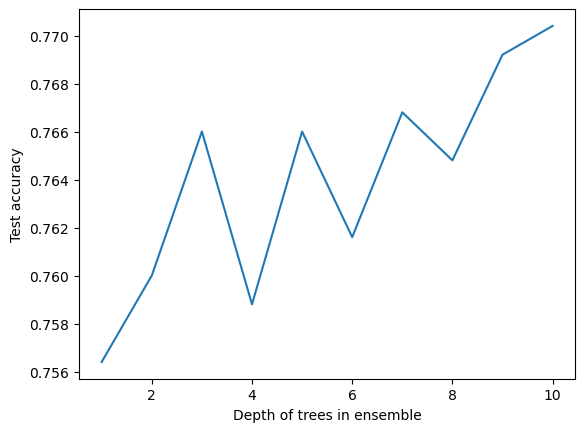

In [17]:
# testing different values for maximum depth to see which value should produce the highest accuracy
scores = {}
for depth in range(1, 11):
    model = GradientBoostingClassifier(n_estimators=200,
                                       max_depth=depth,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot(xlabel = 'Depth of trees in ensemble', ylabel = 'Test accuracy')

However, after testing other values for the number of trees selected and the maximum depth of the trees, we can see that a model with a max depth of 10 and 100 trees would work better. We will rerun the model with these values.

In [18]:
# rerunning the model with the values we found
model = GradientBoostingClassifier(n_estimators=100,
                               max_depth=10,
                               random_state=1)
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
accuracy_test = metrics.accuracy_score(y_test, prediction_test)
accuracy_test

0.7708

Our new model is now  able to predict whether the article is positive or negative with an accuracy of 77.08%. We will now look at which words have a large difference between their usage in the positive articles and in the negative articles, in order to try to decipher which words are model relies in to make its classifications. 

In [19]:
# find the percent change in the average usage of a word when the article is positive instead of negative
df = pd.concat([traindf, testdf], axis = 0)
df = df.groupby(['happy']).mean().T
df['change'] = (df[True] - df[False])*(100/df[False])
df

happy,False,True,change
said,8.189212,8.081950,-1.309793
's,6.012448,6.046377,0.564307
'',5.688797,5.620026,-1.208873
``,5.661411,5.573650,-1.550166
year,2.004979,2.628722,31.109686
...,...,...,...
still,0.440664,0.466930,5.960613
develop,0.466390,0.621080,33.167588
comput,0.687137,1.110935,61.675991
around,0.455602,0.515415,13.128433


<Axes: >

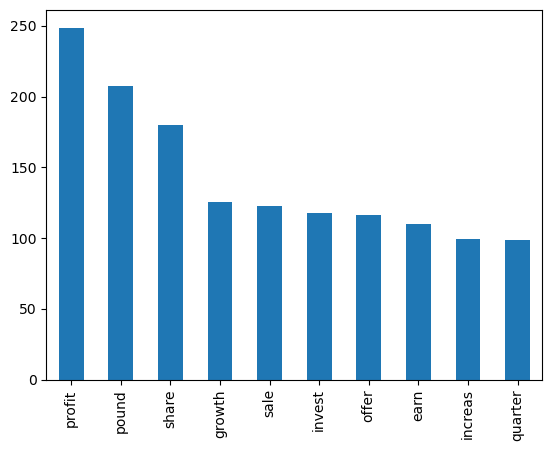

In [20]:
# graph the 10 words that are used the most in positive articles when compared to negative articles
df['change'].sort_values(ascending = False)[:10].plot(kind = 'bar')

<Axes: >

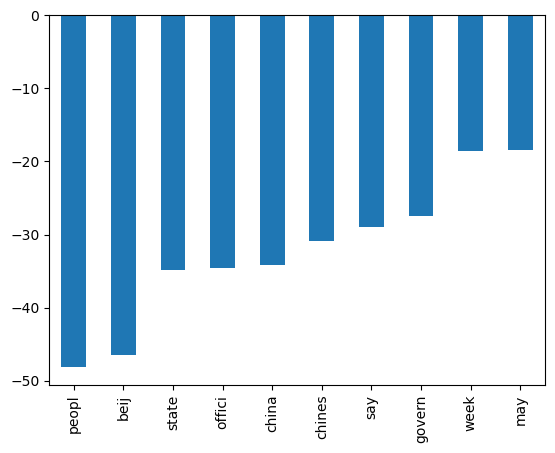

In [21]:
# graph the 10 words that are used the most in positive articles when compared to negative articles
df['change'].sort_values(ascending = True)[:10].plot(kind = 'bar')

## Conclusion

Our most accurate model produces an accuracy of 77.08% when attempting to predict whether an article is positive or negative based on the usage of the 100 most common tokens across the entire data set. Furthermore, we found that the tokens profit, pound, share, growth and sale, among others, were used over 100% more in positive articles than negative articles. On the other hand, we found that tokens like peopl, state, china and govern, among others, were used over 25% less in positive articles than negative articles. Stakeholders in a publishing company can use this information when deciding how they want their articles to be worded. For example, if they want to produce a positive article because the public is responding to positivity, they can make sure to word their article in a way that showcases the growth, profits and sales of the topic they are writing about. However, if they think the public will respond to more negativity, they can word their article to focus on people, the government, or unfriendly foreign states, such as China.